In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Reading 

import os
from glob import glob
import pathlib

# Data Processing 

import numpy as np
import pandas as pd
import cv2
import random

# Data Analysis

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Data Modeling & Model Evaluation

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

# Grad-CAM

import keras
import matplotlib.cm as cm

In [2]:
levels = ['Normal', 'COVID']
path = "C:/Users/DELL/Desktop/works/DATASETS"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Negative', 'COVID': 'Positive'})
samples = 13808


In [3]:
data.head()

image_file corona_result  \
0  Normal/IM-0160-0001.jpeg      Negative   
1  Normal/IM-0162-0001.jpeg      Negative   
2  Normal/IM-0164-0001.jpeg      Negative   
3  Normal/IM-0166-0001.jpeg      Negative   
4  Normal/IM-0168-0001.jpeg      Negative   

                                                path  
0  C:/Users/DELL/Desktop/works/DATASETS/Normal/IM...  
1  C:/Users/DELL/Desktop/works/DATASETS/Normal/IM...  
2  C:/Users/DELL/Desktop/works/DATASETS/Normal/IM...  
3  C:/Users/DELL/Desktop/works/DATASETS/Normal/IM...  
4  C:/Users/DELL/Desktop/works/DATASETS/Normal/IM...

In [4]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 302


In [5]:
# Exploratory Data Analysis

In [6]:
df = pd.DataFrame()
df['corona_result'] = ['Positive', 'Negative']
df['Count'] = [len(data[data['corona_result'] == 'Positive']), len(data[data['corona_result'] == 'Negative'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'corona_result', y = 'Count', 
             color = "corona_result", text_auto='', width = 600, 
             color_discrete_sequence = ["orange", "purple"],
             template = 'plotly_dark')

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

In [7]:
# Image Samples

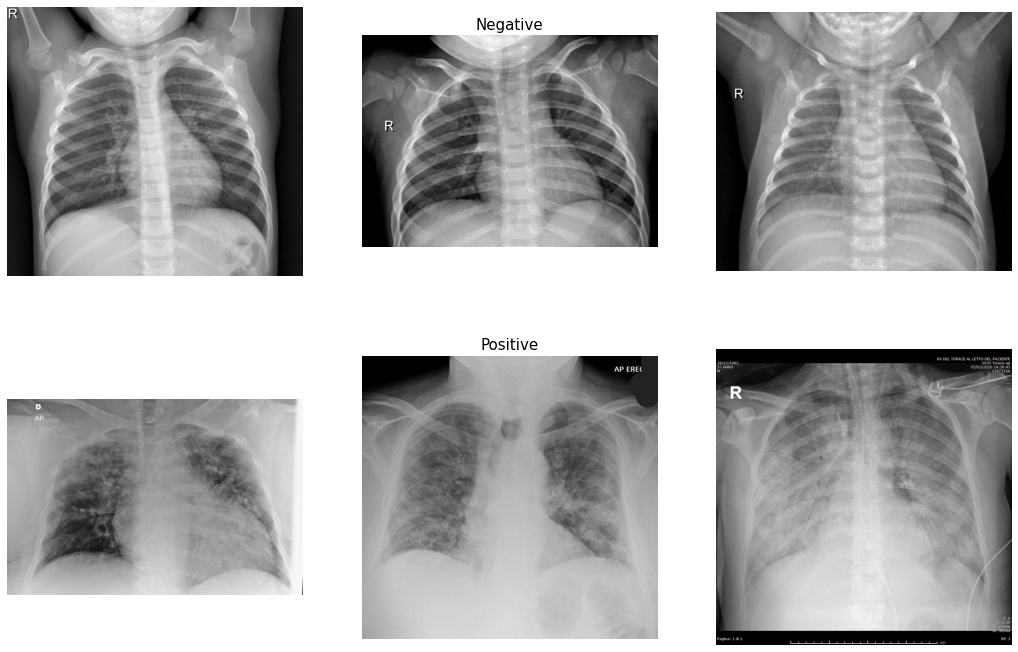

In [8]:
n_samples = 3

fig, m_axs = plt.subplots(2, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['corona_result']).groupby('corona_result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

In [9]:
all_covid = []
all_normal = []

all_normal.extend(glob(os.path.join(path, "Normal/*.png")))
all_covid.extend(glob(os.path.join(path, "COVID/*.png")))

random.shuffle(all_normal)
random.shuffle(all_covid)

images = all_normal[:50] + all_covid[:50]

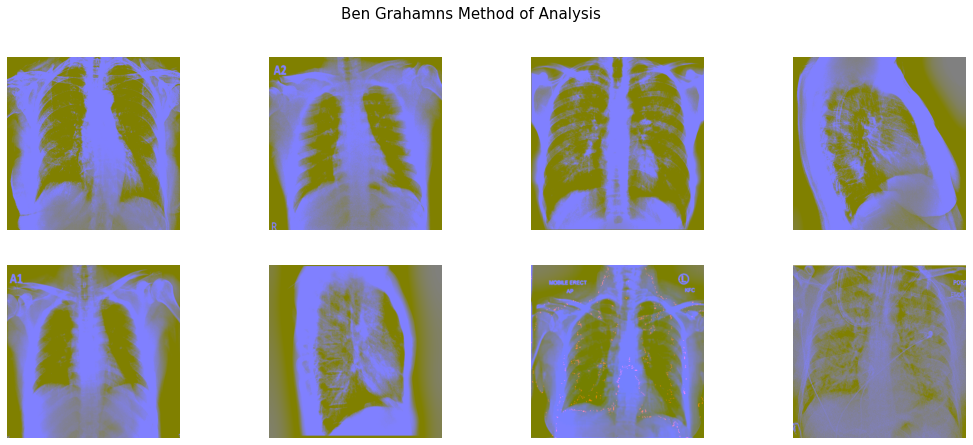

In [10]:
fig = plt.figure(figsize = (18, 7))
fig.suptitle("Ben Grahamns Method of Analysis", fontsize = 15)
columns = 4; rows = 2

for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

In [11]:
# Data Modeling

In [12]:
all_data = []

# Storing images and their labels into a list for further Train Test split

for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 1 if data['corona_result'][i] == "Positive" else 0
    all_data.append([image, label])

In [13]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(216, 70, 70, 3) (61, 70, 70, 3) (25, 70, 70, 3) (216,) (61,) (25,)


In [14]:
# CNN Model

In [15]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Dense(units = 2))

cnn_model.compile(optimizer = 'adam', 
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
           metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 34, 34, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [16]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

#tf.random.set_seed(42)
history = cnn_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/50
1/1 [==============================] - 17s 17s/step - loss: 0.7065 - accuracy: 0.5046 - val_loss: 0.7079 - val_accuracy: 0.4800
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.7491 - accuracy: 0.5046 - val_loss: 0.6868 - val_accuracy: 0.6400
Epoch 3/50
1/1 [==============================] - 3s 3s/step - loss: 0.6827 - accuracy: 0.5370 - val_loss: 0.6870 - val_accuracy: 0.5200
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: 0.6966 - accuracy: 0.4491 - val_loss: 0.6859 - val_accuracy: 0.5200
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 0.6875 - accuracy: 0.4907 - val_loss: 0.6846 - val_accuracy: 0.8800
Epoch 6/50
1/1 [==============================] - 3s 3s/step - loss: 0.6767 - accuracy: 0.5648 - val_loss: 0.6825 - val_accuracy: 0.7200
Epoch 7/50
1/1 [==============================] - 3s 3s/step - loss: 0.6762 - accuracy: 0.6343 - val_loss: 0.6791 - val_accuracy: 0.4800
Epoch 8/50
1/1 [=======================

In [17]:
yp_train = cnn_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = cnn_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = cnn_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

2/2 [==============================] - 0s 69ms/step


In [18]:
# Model Evaluation

In [19]:
def evaluation_parametrics(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train, yp_train),4))
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train, yp_train),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
       
    cm_val = confusion_matrix(y_val, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val, yp_val),4))
    print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val, yp_val),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val),4))
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test, yp_test), 4))
    print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()   
    t3.plot()


-----------------------------Convolution Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       107
           1       0.99      0.89      0.94       109

    accuracy                           0.94       216
   macro avg       0.94      0.94      0.94       216
weighted avg       0.94      0.94      0.94       216

--------------------------------------------------------------------------
Recall on Train Data:  0.8899
Specificity on Train Data:  0.9907
Accuracy on Train Data:  0.9398
Precision on Train Data:  0.9898
F1 Score on Train Data:  0.9372
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.92      0.96        12

    accuracy                

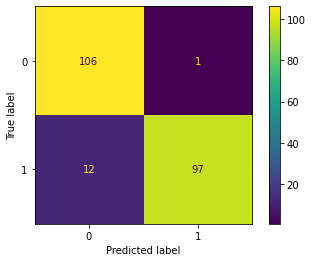

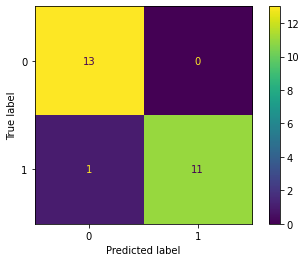

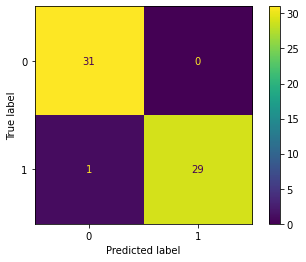

In [20]:
evaluation_parametrics("Convolution Neural Network", y_train, yp_train, y_val, yp_val, y_test, yp_test)

In [21]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [22]:
# Summarize History for Accuracy

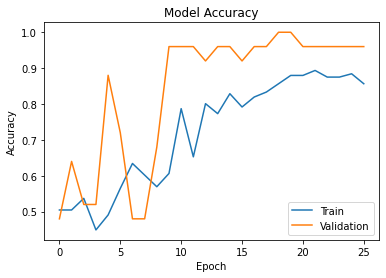

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

In [24]:
# Summarize History for Loss

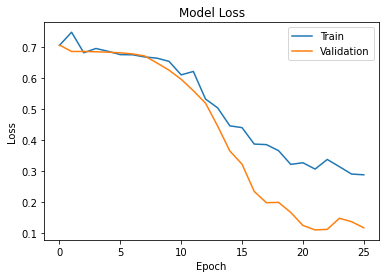

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

In [26]:
# Image Analysis using Grad-CAM¶

In [27]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "block14_sepconv2_act"

# Reading 2 Covid & 2 Normal Images for Grad-Cam Analysis

img_path = ["C:/Users/DELL/Desktop/works/DATASETS/covid-1002.png",
            "C:/Users/DELL/Desktop/works/DATASETS/covid-101.png",
            "C:/Users/DELL/Desktop/works/DATASETS/normal-10004.png",
           "C:/Users/DELL/Desktop/works/DATASETS/normal-10002.png"]

In [28]:
# Storing Heatmap values into list

tf.keras.utils.load_img

<function keras.utils.image_utils.load_img(path, grayscale=False, color_mode='rgb', target_size=None, interpolation='nearest', keep_aspect_ratio=False)>